# IMPORTATIONS

**Librairies**

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
plt.style.use('ggplot')

**Loading the data into a dataframe**

In [22]:
df = pd.read_csv("../input/nba-general-data/nbalogreg-logistic-regression-exercise-1-QueryResult.csv", delimiter=',')
#df.target_5yrs = df.target_5yrs.map({0.0:"career length < 5 years", 1.0:"career length >= 5 years"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         1340 non-null   object 
 1   gp           1340 non-null   int64  
 2   min          1340 non-null   float64
 3   pts          1340 non-null   float64
 4   fgm          1340 non-null   float64
 5   fga          1340 non-null   float64
 6   fg           1340 non-null   float64
 7   3p_made      1340 non-null   float64
 8   3pa          1340 non-null   float64
 9   3p           1329 non-null   float64
 10  ftm          1340 non-null   float64
 11  fta          1340 non-null   float64
 12  ft           1340 non-null   float64
 13  oreb         1340 non-null   float64
 14  dreb         1340 non-null   float64
 15  reb          1340 non-null   float64
 16  ast          1340 non-null   float64
 17  stl          1340 non-null   float64
 18  blk          1340 non-null   float64
 19  tov   

# EDA

In [23]:
df.describe()

,gp,min,pts,fgm,fga,fg,3p_made,3pa,3p,ftm,fta,ft,oreb,dreb,reb,ast,stl,blk,tov,target_5yrs
count,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1329.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000
mean,60.414179,17.624627,6.801493,2.629104,5.885299,44.169403,0.247612,0.779179,19.308126,1.297687,1.821940,70.300299,1.009403,2.025746,3.034478,1.550522,0.618507,0.368582,1.193582,0.620149
std,17.433992,8.307964,4.357545,1.683555,3.593488,6.137679,0.383688,1.061847,16.022916,0.987246,1.322984,10.578479,0.777119,1.360008,2.057774,1.471169,0.409759,0.429049,0.722541,0.485531
min,11.000000,3.100000,0.700000,0.300000,0.800000,23.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.300000,0.000000,0.000000,0.000000,0.100000,0.000000
25%,47.000000,10.875000,3.700000,1.400000,3.300000,40.200000,0.000000,0.000000,0.000000,0.600000,0.900000,64.700000,0.400000,1.000000,1.500000,0.600000,0.300000,0.100000,0.700000,0.000000
50%,63.000000,16.100000,5.550000,2.100000,4.800000,44.100000,0.100000,0.300000,22.400000,1.000000,1.500000,71.250000,0.800000,1.700000,2.500000,1.100000,0.500000,0.200000,1.000000,1.000000
75%,77.000000,22.900000,8.800000,3.400000,7.500000,47.900000,0.400000,1.200000,32.500000,1.600000,2.300000,77.600000,1.400000,2.600000,4.000000,2.000000,0.800000,0.500000,1.500000,1.000000
max,82.000000,40.900000,28.200000,10.200000,19.800000,73.700000,2.300000,6.500000,100.000000,7.700000,10.200000,100.000000,5.300000,9.600000,13.900000,10.600000,2.500000,3.900000,4.400000,1.000000


In [24]:
corr = df.corr()
corr

,gp,min,pts,fgm,fga,fg,3p_made,3pa,3p,ftm,fta,ft,oreb,dreb,reb,ast,stl,blk,tov,target_5yrs
gp,1.000000,0.590240,0.538471,0.542724,0.516625,0.296289,0.107423,0.098772,0.038209,0.482123,0.479487,0.196299,0.401136,0.466840,0.460406,0.372749,0.451137,0.276498,0.518167,0.396833
min,0.590240,1.000000,0.911822,0.903060,0.910247,0.203901,0.389920,0.403258,0.165997,0.791000,0.779609,0.239878,0.573062,0.745513,0.709707,0.629015,0.757034,0.399088,0.826500,0.317805
pts,0.538471,0.911822,1.000000,0.990834,0.979733,0.255333,0.346682,0.356751,0.151072,0.896297,0.880703,0.258931,0.575106,0.693934,0.676849,0.552338,0.675341,0.387043,0.850366,0.315981
fgm,0.542724,0.903060,0.990834,1.000000,0.980050,0.291693,0.289007,0.299057,0.119493,0.848019,0.840408,0.223566,0.596687,0.703278,0.691186,0.532534,0.662640,0.398125,0.834352,0.317594
fga,0.516625,0.910247,0.979733,0.980050,1.000000,0.129798,0.390253,0.413560,0.197160,0.826616,0.805559,0.269614,0.504212,0.640123,0.614328,0.589818,0.690168,0.322184,0.845989,0.292660
fg,0.296289,0.203901,0.255333,0.291693,0.129798,1.000000,-0.294471,-0.350658,-0.330690,0.245776,0.300154,-0.161183,0.511367,0.410555,0.465423,-0.108797,0.056658,0.391626,0.121806,0.227134
3p_made,0.107423,0.389920,0.346682,0.289007,0.390253,-0.294471,1.000000,0.982616,0.589855,0.158472,0.095396,0.314355,-0.219010,0.016570,-0.072503,0.376604,0.306908,-0.158535,0.258369,0.036619
3pa,0.098772,0.403258,0.356751,0.299057,0.413560,-0.350658,0.982616,1.000000,0.582337,0.173533,0.108388,0.323612,-0.231897,0.011226,-0.080939,0.410531,0.338631,-0.172150,0.283925,0.018110
3p,0.038209,0.165997,0.151072,0.119493,0.197160,-0.330690,0.589855,0.582337,1.000000,0.030320,-0.032333,0.326372,-0.288759,-0.122949,-0.191071,0.262120,0.194329,-0.242274,0.108277,-0.003411
ftm,0.482123,0.791000,0.896297,0.848019,0.826616,0.245776,0.158472,0.173533,0.030320,1.000000,0.980505,0.257818,0.583865,0.653823,0.653833,0.476214,0.600158,0.407466,0.804990,0.296841


<AxesSubplot:xlabel='target_5yrs', ylabel='count'>

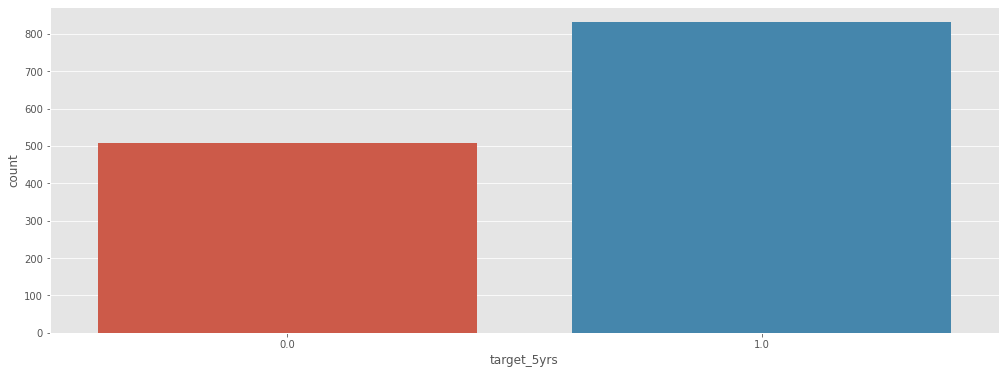

In [25]:
f, axes = plt.subplots(ncols=1,figsize=(17,6))

sns.countplot(x='target_5yrs',ax=axes,data=df)

We see here that we have a slightly unbalanced dataset, as we have a little more players with a career of more than 5 years.

<AxesSubplot:>

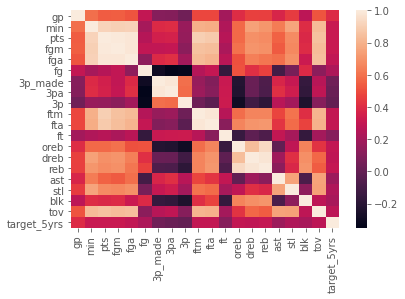

In [26]:
sns.heatmap(corr)

Here we see that the correlation coefficients between target_5yrs and the other variables don't tell us much, given that they are all quite close. In summary, they are positive, so we can conclude that their increase will promote the length of a player's career, but there are no variables that really stand out from the others. The variable with the highest correlation rate with target_5yrs happens to be gp, the number of matches played.

With this in mind, we will determine the variables to favor by studying the stripplots of the different variables with target_5yrs.

<AxesSubplot:xlabel='target_5yrs', ylabel='stl'>

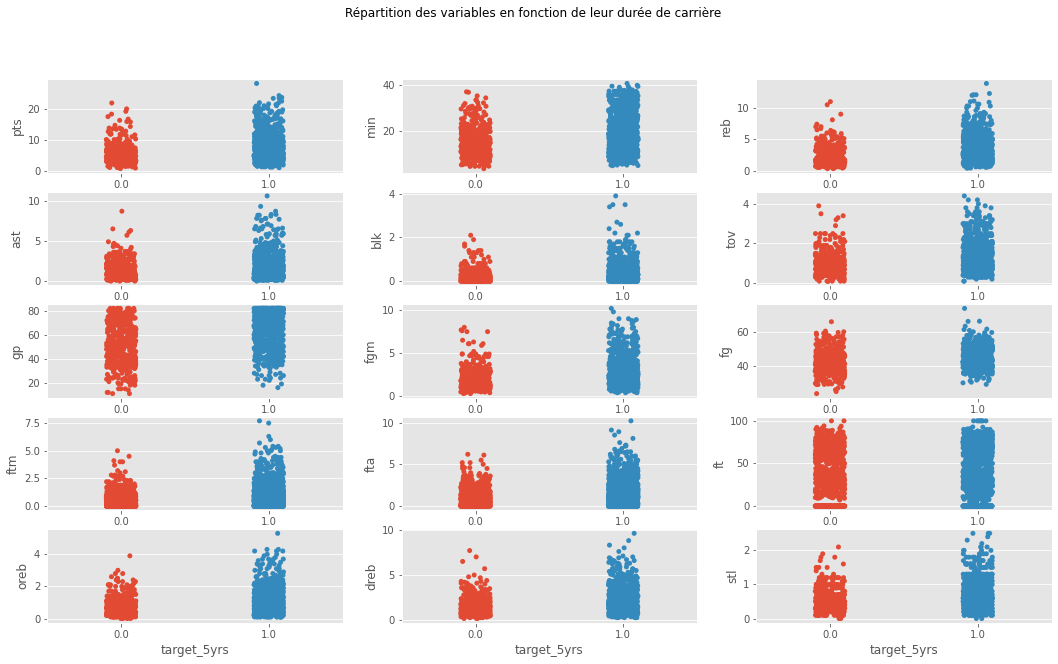

In [27]:
fig, axes = plt.subplots(5, 3, figsize=(18, 10))

fig.suptitle('Répartition des variables en fonction de leur durée de carrière')

sns.stripplot(ax=axes[0, 0], data=df, x='target_5yrs', y='pts')
sns.stripplot(ax=axes[0, 1], data=df, x='target_5yrs', y='min')
sns.stripplot(ax=axes[0, 2], data=df, x='target_5yrs', y='reb')
sns.stripplot(ax=axes[1, 0], data=df, x='target_5yrs', y='ast')
sns.stripplot(ax=axes[1, 1], data=df, x='target_5yrs', y='blk')
sns.stripplot(ax=axes[1, 2], data=df, x='target_5yrs', y='tov')
sns.stripplot(ax=axes[2, 0], data=df, x='target_5yrs', y='gp')
sns.stripplot(ax=axes[2, 1], data=df, x='target_5yrs', y='fgm')
sns.stripplot(ax=axes[2, 2], data=df, x='target_5yrs', y='fg')
sns.stripplot(ax=axes[3, 0], data=df, x='target_5yrs', y='3p_made')
sns.stripplot(ax=axes[3, 1], data=df, x='target_5yrs', y='3pa')
sns.stripplot(ax=axes[3, 2], data=df, x='target_5yrs', y='3p')
sns.stripplot(ax=axes[3, 0], data=df, x='target_5yrs', y='ftm')
sns.stripplot(ax=axes[3, 1], data=df, x='target_5yrs', y='fta')
sns.stripplot(ax=axes[3, 2], data=df, x='target_5yrs', y='ft')
sns.stripplot(ax=axes[4, 0], data=df, x='target_5yrs', y='oreb')
sns.stripplot(ax=axes[4, 1], data=df, x='target_5yrs', y='dreb')
sns.stripplot(ax=axes[4, 2], data=df, x='target_5yrs', y='stl')

Here we can clearly see that ten variables are really relevant to distinguish a player who will have a career lasting more than 5 years: pts, reb, ast, tov, fgm, ftm, fta, oreb, dreb, stl, blk.

We will choose here to consider certain data by processing them "per match played", like the variable pts.

In [28]:
def by_game(df, variable):
    df[str(variable) + "_by_game"] = df[variable]/df.gp

for var in ["pts","min","tov","blk","ast","stl","reb","fgm","ftm","fta","oreb","dreb"]:
    by_game(df, var)
    df = df.drop(var,axis=1)

df.head()

,name,gp,fga,fg,3p_made,3pa,3p,ft,target_5yrs,pts_by_game,...,tov_by_game,blk_by_game,ast_by_game,stl_by_game,reb_by_game,fgm_by_game,ftm_by_game,fta_by_game,oreb_by_game,dreb_by_game
0,Brandon Ingram,36,7.6,34.7,0.5,2.1,25.0,69.9,0.0,0.205556,...,0.036111,0.011111,0.052778,0.011111,0.113889,0.072222,0.044444,0.063889,0.019444,0.094444
1,Andrew Harrison,35,6.7,29.6,0.7,2.8,23.5,76.5,0.0,0.205714,...,0.045714,0.014286,0.105714,0.031429,0.068571,0.057143,0.074286,0.097143,0.014286,0.057143
2,JaKarr Sampson,74,4.7,42.2,0.4,1.7,24.4,67.0,0.0,0.070270,...,0.013514,0.004054,0.013514,0.006757,0.029730,0.027027,0.012162,0.017568,0.006757,0.022973
3,Malik Sealy,58,5.5,42.6,0.1,0.5,22.6,68.9,1.0,0.098276,...,0.017241,0.001724,0.013793,0.010345,0.032759,0.039655,0.015517,0.022414,0.017241,0.015517
4,Matt Geiger,48,3.0,52.4,0.0,0.1,0.0,67.4,1.0,0.093750,...,0.016667,0.008333,0.006250,0.006250,0.052083,0.033333,0.027083,0.039583,0.020833,0.031250


Now, we remove the non-useful variables:

In [29]:
for column in df.columns:
    if "_by_game" not in column and "target_5yrs" not in column:
        df = df.drop(column,axis=1)

df.columns

Index(['target_5yrs', 'pts_by_game', 'min_by_game', 'tov_by_game',
       'blk_by_game', 'ast_by_game', 'stl_by_game', 'reb_by_game',
       'fgm_by_game', 'ftm_by_game', 'fta_by_game', 'oreb_by_game',
       'dreb_by_game'],
      dtype='object')

In [30]:
shuffled_rows = np.random.permutation(df.index)
df = df.iloc[shuffled_rows]
df.head()
df.isnull().sum()

target_5yrs     0
pts_by_game     0
min_by_game     0
tov_by_game     0
blk_by_game     0
ast_by_game     0
stl_by_game     0
reb_by_game     0
fgm_by_game     0
ftm_by_game     0
fta_by_game     0
oreb_by_game    0
dreb_by_game    0
dtype: int64

In [31]:
df.corr()["pts_by_game"]

target_5yrs     0.120836
pts_by_game     1.000000
min_by_game     0.848029
tov_by_game     0.764488
blk_by_game     0.315399
ast_by_game     0.497333
stl_by_game     0.638809
reb_by_game     0.592536
fgm_by_game     0.986018
ftm_by_game     0.852955
fta_by_game     0.833020
oreb_by_game    0.468743
dreb_by_game    0.616491
Name: pts_by_game, dtype: float64

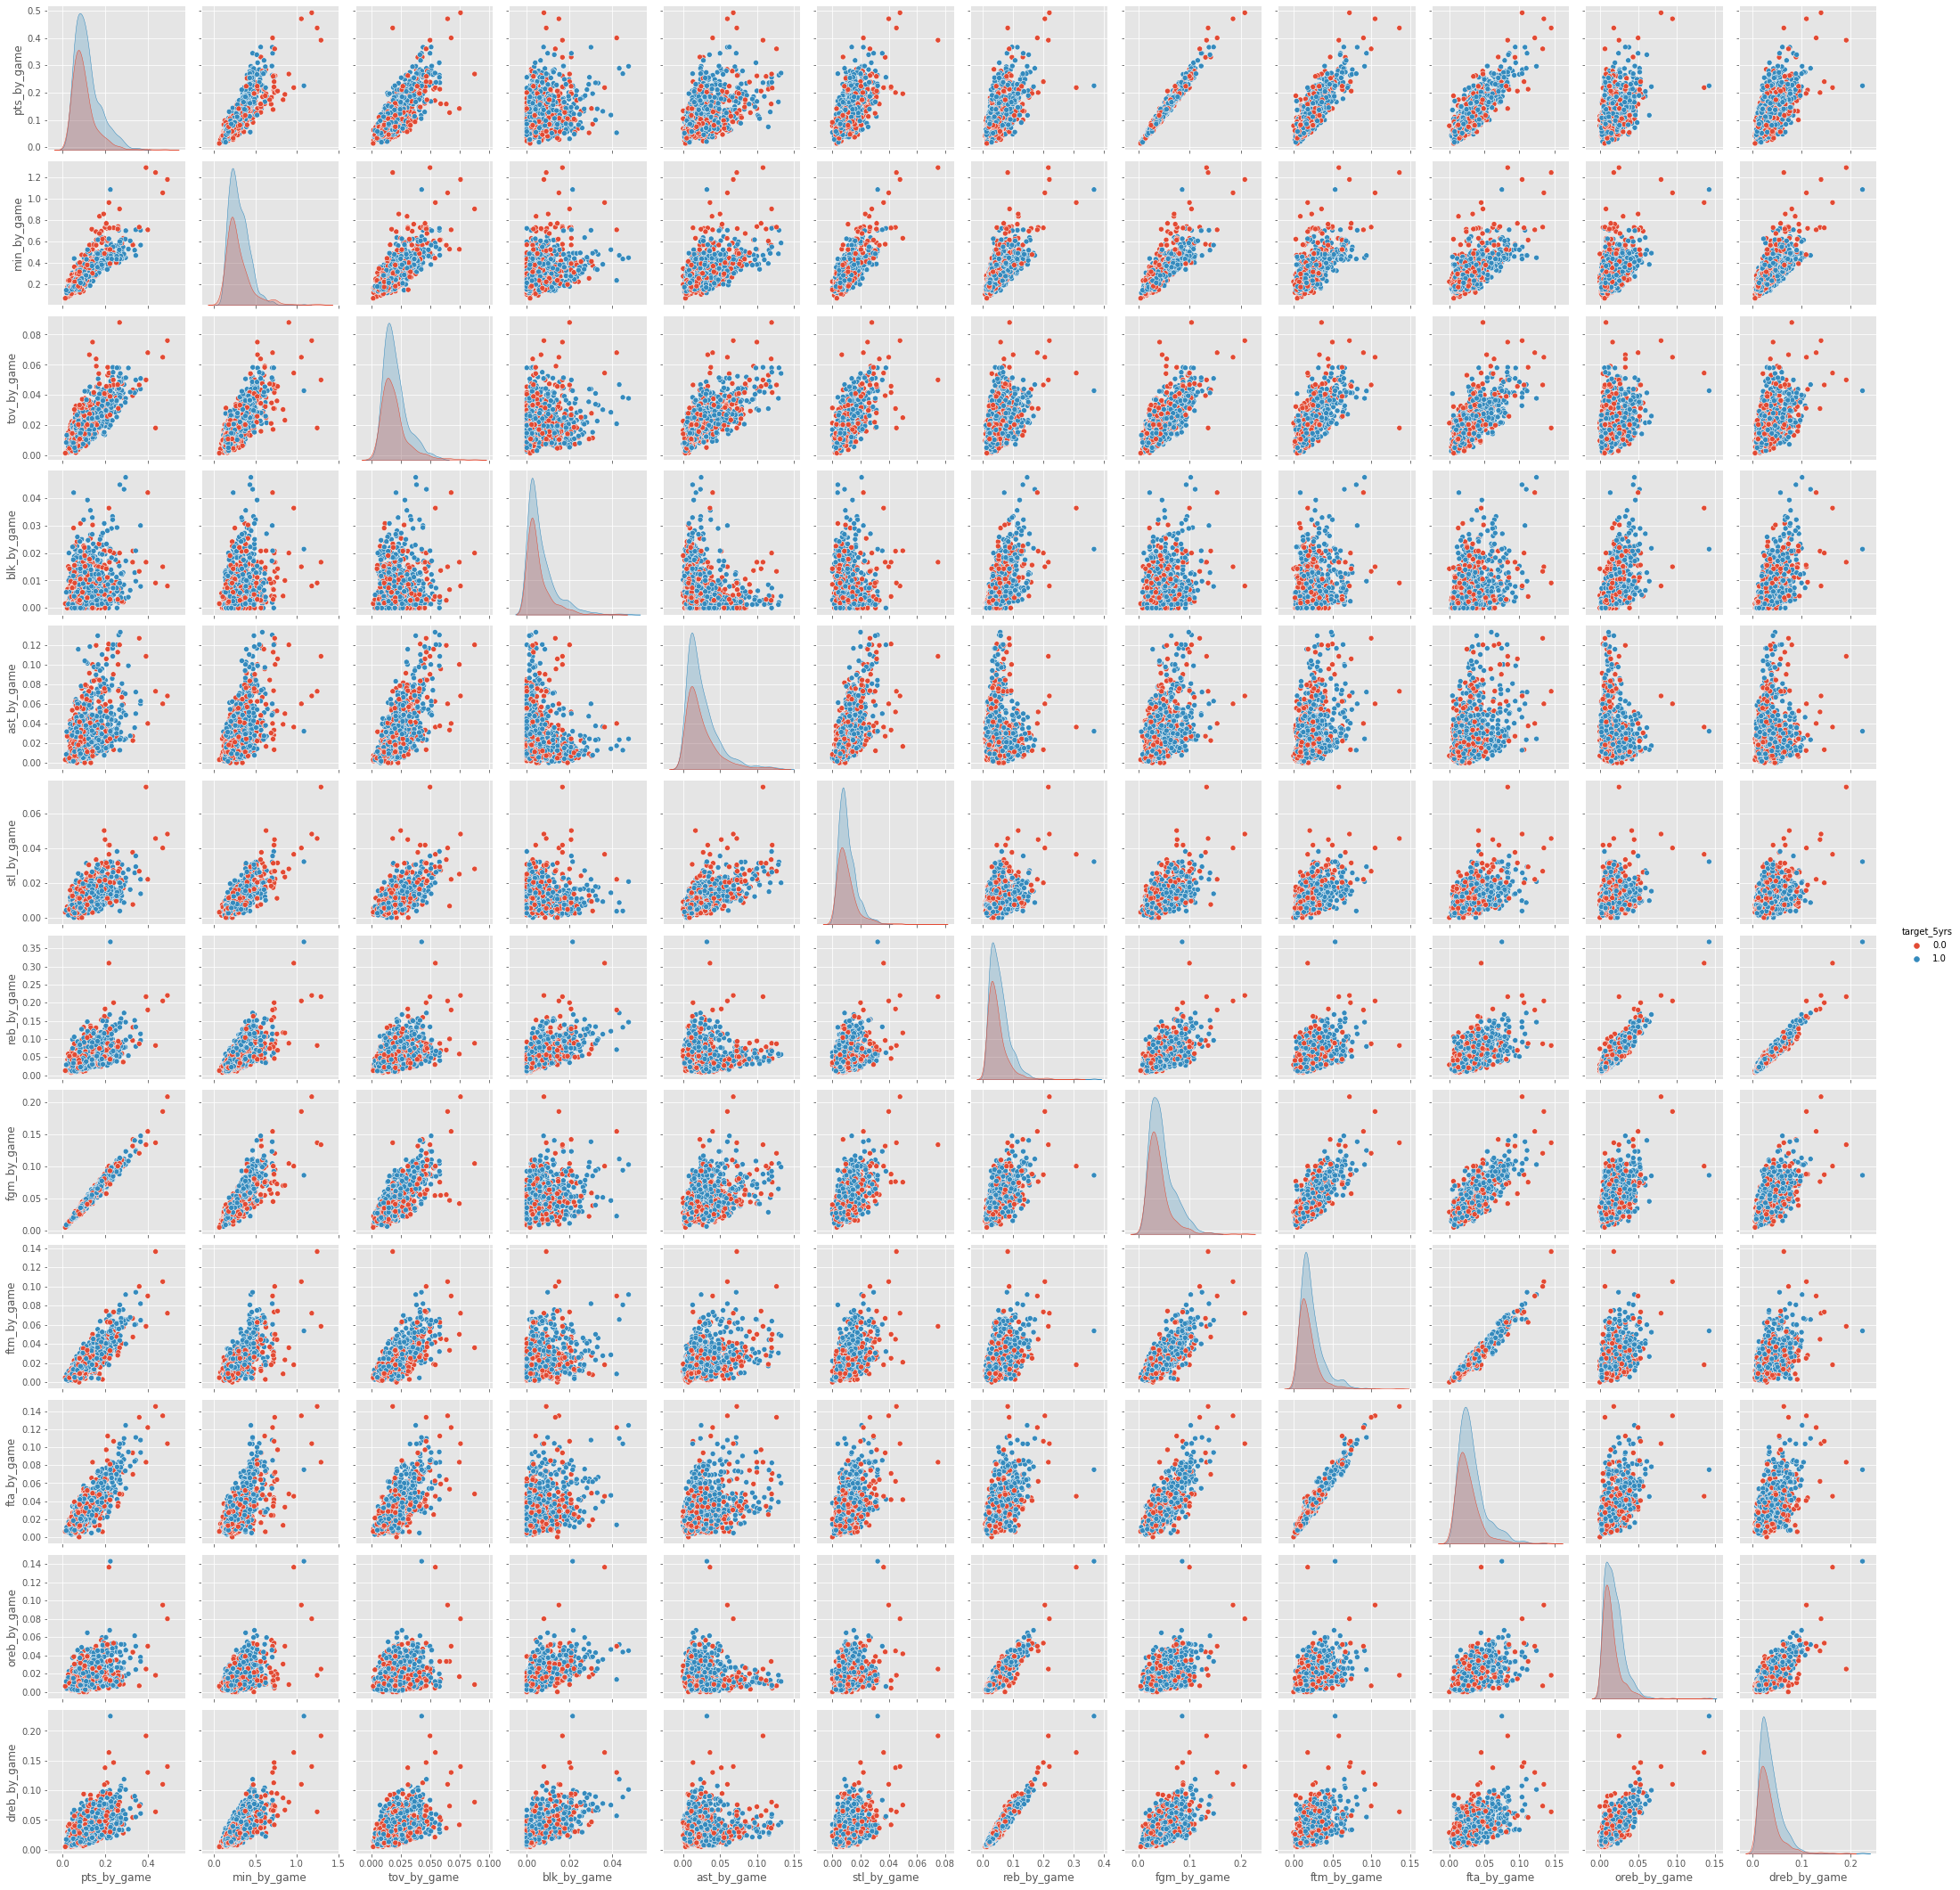

In [32]:
sns.pairplot(df, hue="target_5yrs")

## Implementation of models and tests

Here we will use the given test function with the subject. However, we have modified it somewhat: it has been separated into two functions; one performing the prediction on the test set, and the other on the practice set. The second will be used to determine if a model is overfitting.

In [33]:
df.drop(['target_5yrs'],axis=1).columns.values

array(['pts_by_game', 'min_by_game', 'tov_by_game', 'blk_by_game',
       'ast_by_game', 'stl_by_game', 'reb_by_game', 'fgm_by_game',
       'ftm_by_game', 'fta_by_game', 'oreb_by_game', 'dreb_by_game'],
      dtype=object)

In [34]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.svm import SVC

def score_classifier_test(dataset,classifier,labels):

    """
    performs 3 random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    :return:
    """

    kf = KFold(n_splits=3,random_state=50,shuffle=True)
    confusion_mat = np.zeros((2,2))
    recall = 0
    for training_ids,test_ids in kf.split(dataset):
        training_set = dataset[training_ids]
        training_labels = labels[training_ids]
        test_set = dataset[test_ids]
        test_labels = labels[test_ids]
        classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(test_set)
        confusion_mat+=confusion_matrix(test_labels,predicted_labels)
        recall += recall_score(test_labels, predicted_labels)
    recall/=3
    return(confusion_mat, recall)

def score_classifier_train(dataset,classifier,labels):

    """
    performs 3 random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    :return:
    """

    kf = KFold(n_splits=3,random_state=50,shuffle=True)
    confusion_mat = np.zeros((2,2))
    recall = 0
    for training_ids,test_ids in kf.split(dataset):
        training_set = dataset[training_ids]
        training_labels = labels[training_ids]
        test_set = dataset[test_ids]
        test_labels = labels[test_ids]
        classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(training_set)
        confusion_mat+=confusion_matrix(training_labels,predicted_labels)
        recall += recall_score(training_labels, predicted_labels)
    recall/=3
    return(confusion_mat, recall)

**Set up of models and test function**

Similarly, we have modified this part as well by removing the drops from the 'name' variable since we had already done so before.

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

lr = LogisticRegression()
mlp = MLPClassifier()
rf = RandomForestClassifier()
svc = SVC()

def test_model(model, type):
    # extract names, labels, features names and values
    labels = df['target_5yrs'].values # labels
    paramset = df.drop(['target_5yrs'],axis=1).columns.values
    df_vals = df.drop(['target_5yrs'],axis=1).values

    # replacing Nan values (only present when no 3 points attempts have been performed by a player)
    for x in np.argwhere(np.isnan(df_vals)):
        df_vals[x]=0.0

    # normalize dataset
    X = MinMaxScaler().fit_transform(df_vals)

    #example of scoring with support vector classifier
    if (type == 'test'): # test predictions
        return score_classifier_test(X,model,labels)
    else: # train predictions to conclude on the overfitting
        return score_classifier_train(X,model,labels)



**Model test**

In [36]:
accuracy_lr = test_model(lr,'test')[1]
accuracy_mlp = test_model(mlp,'test')[1]
accuracy_rf = test_model(rf,'test')[1]
accuracy_svc = test_model(svc,'test')[1]

print('Test Accuracy of Logistic Regression: %.3f' % accuracy_lr)
print('Test Accuracy of MLP: %.3f' % accuracy_mlp)
print('Test Accuracy of Random Forest: %.3f' % accuracy_rf)
print('Test Accuracy of SVC: %.3f' % accuracy_svc)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Test Accuracy of Logistic Regression: 0.992
Test Accuracy of MLP: 0.893
Test Accuracy of Random Forest: 0.782
Test Accuracy of SVC: 0.946


**Overfitting tests**

In [37]:
accuracy_lr = test_model(lr,'train')[1]
accuracy_mlp = test_model(mlp,'train')[1]
accuracy_rf = test_model(rf,'train')[1]
accuracy_svc = test_model(svc,'train')[1]

print('Train Accuracy of Logistic Regression: %.3f' % accuracy_lr)
print('Train Accuracy of MLP: %.3f' % accuracy_mlp)
print('Train Accuracy of Random Forest: %.3f' % accuracy_rf)
print('Train Accuracy of SVC: %.3f' % accuracy_svc)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Train Accuracy of Logistic Regression: 0.993
Train Accuracy of MLP: 0.904
Train Accuracy of Random Forest: 0.995
Train Accuracy of SVC: 0.958


The only model that seems to significantly overfit is the Random Forest. It seems obvious here that the model to choose is therefore the logistic regression model.

**Save the model**

In [38]:
import pickle


Pkl_Filename = "lr.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(lr, file)